In [1]:
import pandas as pd
import numpy as np
import re

def generar_variaciones(df: pd.DataFrame, n_variaciones: int = 20) -> pd.DataFrame:
    """
    Para cada fila de df genera `n_variaciones` filas nuevas,
    cada una de longitud 12 (enero–diciembre), escogiendo aleatoriamente
    el valor de 2023 o 2024 en cada posición de mes.

    Además conserva:
      - La columna ID de tienda (primera columna)
      - La columna ENTORNO_DES (categoría)
    """
    # Identificamos nombres de columnas
    id_col   = df.columns[0]
    env_col  = "ENTORNO_DES"

    # Solo columnas YYYYMM (6 dígitos)
    date_cols = [c for c in df.columns[1:]
                 if isinstance(c, str) and re.fullmatch(r'\d{6}', c)]

    # Map mes → lista de columnas para ese mes
    month_map = {}
    for col in date_cols:
        mes = int(col[4:6])  # extrae "MM"
        month_map.setdefault(mes, []).append(col)

    filas = []
    for _, row in df.iterrows():
        tienda = row[id_col]
        entorno = row[env_col]
        for _ in range(n_variaciones):
            nueva = {
                id_col: tienda,
                env_col: entorno
            }
            # Para cada mes 1..12, elegimos 2023 o 2024
            for m in range(1, 13):
                opts = month_map.get(m, [])
                if not opts:
                    nueva[f"mes_{m:02d}"] = np.nan
                elif len(opts) == 1:
                    nueva[f"mes_{m:02d}"] = row[opts[0]]
                else:
                    elegida = np.random.choice(opts)
                    nueva[f"mes_{m:02d}"] = row[elegida]
            filas.append(nueva)

    # Columnas en orden: ID, ENTORNO_DES, mes_01 … mes_12
    cols_salida = [id_col, env_col] + [f"mes_{m:02d}" for m in range(1, 13)]
    return pd.DataFrame(filas, columns=cols_salida)



In [2]:
df_test = pd.read_csv(r"C:\Users\audi_\Downloads\Test_imputado_delta_clean.csv")

In [3]:

df_test = generar_variaciones(df_test, n_variaciones=20)
print(df_test.shape)  
# debería ser (20 * len(df_filtrado), 13)  
# columnas: [ID_tienda, mes_01, mes_02, …, mes_12]


(1980, 14)


In [4]:
df_test

,ID,ENTORNO_DES,mes_01,mes_02,mes_03,mes_04,mes_05,mes_06,mes_07,mes_08,mes_09,mes_10,mes_11,mes_12
0,10,Base,538209.11,480121.93,563512.47,495073.33,537980.10,605957.25,580267.92,575396.06,565108.57,488600.02,474839.43,546728.53
1,10,Base,538209.11,480121.93,563512.47,495073.33,669062.13,605957.25,580267.92,575396.06,565108.57,488600.02,474839.43,228085.66
2,10,Base,538209.11,407512.01,563512.47,581288.55,669062.13,605957.25,605000.42,575396.06,565108.57,488600.02,474839.43,546728.53
3,10,Base,538209.11,407512.01,498450.34,495073.33,537980.10,605957.25,580267.92,575396.06,565108.57,488600.02,528134.58,228085.66
4,10,Base,538209.11,407512.01,563512.47,495073.33,669062.13,632414.45,580267.92,575396.06,565108.57,488600.02,474839.43,228085.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,1050,Receso,1192256.18,989660.62,887900.50,916782.71,1000580.47,1287268.61,1057231.37,1014628.57,1192753.90,1082149.37,1142200.02,1206990.36
1976,1050,Receso,340230.93,989660.62,1136565.50,916782.71,1000580.47,994372.20,1265611.68,1014628.57,1192753.90,1082149.37,1142200.02,540780.76
1977,1050,Receso,340230.93,706826.81,887900.50,1109509.85,1378994.80,1287268.61,1057231.37,1014628.57,1192753.90,1082149.37,1142200.02,1206990.36
1978,1050,Receso,340230.93,989660.62,887900.50,1109509.85,1378994.80,994372.20,1265611.68,1014628.57,1192753.90,1082149.37,1056779.09,540780.76


In [5]:
import pandas as pd
import re

def calcular_excesos_y_promedio(df_aug: pd.DataFrame,
                                thresholds: dict) -> (pd.DataFrame, pd.DataFrame):
    """
    Parámetros
    ----------
    df_aug : pd.DataFrame
        DataFrame de variaciones con columnas:
          [ID_tienda, ENTORNO_DES, mes_01, mes_02, …, mes_12]
    thresholds : dict
        Mapeo categoría → umbral numérico, p.ej.
        {'Base':480000, 'Hogar':490000, 'Peatonal':420000, 'Receso':516000}

    Retorna
    -------
    df_contado : pd.DataFrame
        Igual que df_aug, pero con columna adicional 'exceed_count'
        con el conteo de meses > umbral.
    df_prom : pd.DataFrame
        DataFrame con columnas [ID_tienda, ENTORNO_DES, avg_exceed]
        donde avg_exceed es el promedio de exceed_count por tienda.
    """
    # Hacemos copia para no modificar el original
    df = df_aug.copy()
    id_col  = df.columns[0]
    env_col = "ENTORNO_DES"

    # Identificamos dinámicamente las columnas de mes (mes_01 … mes_12)
    mes_cols = [c for c in df.columns if re.fullmatch(r"mes_\d{2}", c)]

    # Función auxiliar: cuenta cuántos meses exceden el umbral
    def _contar(row):
        umbral = thresholds.get(row[env_col])
        if umbral is None:
            raise ValueError(f"No hay umbral definido para {row[env_col]!r}")
        return int((row[mes_cols] > umbral).sum())

    # 1) Calculamos exceed_count
    df["exceed_count"] = df.apply(_contar, axis=1)

    # 2) Promediamos por tienda (y categoría)
    df_prom = (
        df
        .groupby([id_col, env_col], as_index=False)["exceed_count"]
        .mean()
        .rename(columns={"exceed_count": "avg_exceed"})
    )

    return df, df_prom


In [6]:
# Supongamos que `df_aug` ya lo tienes de la función anterior
thresholds = {
    "Base":     480000,
    "Hogar":    490000,
    "Peatonal": 420000,
    "Receso":   516000
}

df_contado, df_promedio = calcular_excesos_y_promedio(df_test, thresholds)

# df_contado tendrá una columna 'exceed_count' por cada vector:
print(df_contado.head(5))

# df_promedio tendrá un registro por tienda con su promedio de meses excedidos:
print(df_promedio.head())


   ID ENTORNO_DES     mes_01     mes_02     mes_03     mes_04     mes_05  \
0  10        Base  538209.11  480121.93  563512.47  495073.33  537980.10   
1  10        Base  538209.11  480121.93  563512.47  495073.33  669062.13   
2  10        Base  538209.11  407512.01  563512.47  581288.55  669062.13   
3  10        Base  538209.11  407512.01  498450.34  495073.33  537980.10   
4  10        Base  538209.11  407512.01  563512.47  495073.33  669062.13   

      mes_06     mes_07     mes_08     mes_09     mes_10     mes_11  \
0  605957.25  580267.92  575396.06  565108.57  488600.02  474839.43   
1  605957.25  580267.92  575396.06  565108.57  488600.02  474839.43   
2  605957.25  605000.42  575396.06  565108.57  488600.02  474839.43   
3  605957.25  580267.92  575396.06  565108.57  488600.02  528134.58   
4  632414.45  580267.92  575396.06  565108.57  488600.02  474839.43   

      mes_12  exceed_count  
0  546728.53            11  
1  228085.66            10  
2  546728.53            10  


In [8]:
df_promedio

,ID,ENTORNO_DES,avg_exceed
0,10,Base,9.90
1,20,Base,11.00
2,30,Base,10.15
3,40,Peatonal,12.00
4,50,Receso,12.00
...,...,...,...
94,1010,Receso,10.80
95,1020,Receso,12.00
96,1030,Peatonal,11.70
97,1040,Receso,12.00


In [9]:
# 3. Ruta donde quieres guardar el nuevo CSV
output_path = r'C:\Users\audi_\Downloads\df_promedioTest.csv'

# 4. Guarda el DataFrame
df_promedio.to_csv(output_path, index=False)

In [10]:
# Número de tiendas con avg_exceed < 8
n_menor_80 = (df_promedio['avg_exceed'] < 9).sum()

# Número de tiendas con avg_exceed >= 8
n_mayor_igual_80 = (df_promedio['avg_exceed'] >= 9).sum()

print(f"Tiendas con avg_exceed < 9: {n_menor_80}")
print(f"Tiendas con avg_exceed ≥ 9: {n_mayor_igual_80}")


Tiendas con avg_exceed < 9: 7
Tiendas con avg_exceed ≥ 9: 92


In [11]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
# 1. Carga el dataset ya codificado
df_train = pd.read_csv(r"C:\Users\audi_\Downloads\principal_imputado_limpio_promedio_delta_estandarizado_encoded_AvD.csv")


In [13]:
df_train

,ID,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,avg_exceed,delta_obj,AvD
0,1,4,1,26.00177,-98.24284,2,1,0.866667,0.173984,0.520326
1,2,4,1,26.04198,-98.35620,2,1,0.958333,0.250070,0.604202
2,3,4,1,26.02464,-98.26098,2,1,0.966667,0.238111,0.602389
3,4,0,1,26.04326,-98.23851,2,1,1.000000,0.362118,0.681059
4,5,4,1,26.06397,-98.26165,2,1,1.000000,0.479223,0.739612
...,...,...,...,...,...,...,...,...,...,...
919,1052,2,0,26.06517,-98.34480,4,1,1.000000,0.325403,0.662701
920,1053,4,1,26.04132,-98.29259,2,1,0.804167,0.215918,0.510042
921,1054,4,1,26.09605,-98.29327,2,1,1.000000,0.410164,0.705082
922,1055,4,1,26.01132,-98.38140,2,1,0.945833,0.272633,0.609233


In [14]:
# 2. Define columnas
cat_cols  = ['NIVELSOCIOECONOMICO_DES','ENTORNO_DES','SEGMENTO_MAESTRO_DESC','LID_UBICACION_TIENDA']
cont_cols = ['LATITUD_NUM','LONGITUD_NUM','delta_obj','avg_exceed']
target_col   = 'AvD'

In [18]:
df_train

,ID,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,avg_exceed,delta_obj,AvD
0,1,4,1,26.00177,-98.24284,2,1,0.866667,0.173984,0.520326
1,2,4,1,26.04198,-98.35620,2,1,0.958333,0.250070,0.604202
2,3,4,1,26.02464,-98.26098,2,1,0.966667,0.238111,0.602389
3,4,0,1,26.04326,-98.23851,2,1,1.000000,0.362118,0.681059
4,5,4,1,26.06397,-98.26165,2,1,1.000000,0.479223,0.739612
...,...,...,...,...,...,...,...,...,...,...
919,1052,2,0,26.06517,-98.34480,4,1,1.000000,0.325403,0.662701
920,1053,4,1,26.04132,-98.29259,2,1,0.804167,0.215918,0.510042
921,1054,4,1,26.09605,-98.29327,2,1,1.000000,0.410164,0.705082
922,1055,4,1,26.01132,-98.38140,2,1,0.945833,0.272633,0.609233


In [19]:
val_df = pd.read_csv(r"C:\Users\audi_\Downloads\Test_imputado_delta_normT.csv")

In [20]:
val_df

,ID,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,delta_obj,avg_exceed,AvD
0,10,0,0,26.02203,-98.27759,3,3,0.058067,0.809278,0.413349
1,20,0,0,25.58304,-99.99446,3,3,0.289330,0.896907,0.491853
2,30,0,0,24.85727,-99.55978,3,3,0.186213,0.881443,0.468654
3,40,0,2,25.30376,-100.00144,0,4,0.904900,1.000000,0.635735
4,50,2,3,25.64554,-100.11852,3,0,0.551116,1.000000,0.582667
...,...,...,...,...,...,...,...,...,...,...
94,1010,0,3,26.07052,-98.32878,3,3,0.460062,0.932990,0.535504
95,1020,0,3,26.00370,-98.21478,3,0,0.590653,1.000000,0.588598
96,1030,0,2,26.40152,-99.02246,2,2,0.078565,0.938144,0.480857
97,1040,0,3,26.22708,-98.59373,3,3,0.428455,1.000000,0.564268


In [21]:
# 4. Estandariza continuas
scaler = StandardScaler()
df_train[cont_cols] = scaler.fit_transform(df_train[cont_cols])
val_df[cont_cols]   = scaler.transform(val_df[cont_cols])

In [22]:
# 5. Dataset tabular
class TabDataset(Dataset):
    def __init__(self, df):
        self.x_cat = torch.tensor(df[cat_cols].values, dtype=torch.long)
        self.x_cont= torch.tensor(df[cont_cols].values, dtype=torch.float)
        self.y     = torch.tensor(df[target_col].values, dtype=torch.float)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x_cat[idx], self.x_cont[idx], self.y[idx]

In [24]:
train_ds = TabDataset(df_train)
val_ds   = TabDataset(val_df)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

In [25]:
# 6. Modelo TabTransformer
class TabTransformer(nn.Module):
    def __init__(self, num_categories, embed_dim=16, num_cont=2, depth=2, heads=2, dropout=0.1):
        super().__init__()
        # Embeddings por variable categórica
        self.embs = nn.ModuleList([
            nn.Embedding(n_cat, embed_dim)
            for n_cat in num_categories
        ])
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        # Normalización de continuas
        self.bn_cont = nn.BatchNorm1d(num_cont)
        # Cabeza final
        total_emb = embed_dim * len(num_categories)
        self.head = nn.Sequential(
            nn.Linear(total_emb + num_cont, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x_cat, x_cont):
        # x_cat: (B, C) -> list de (B, D)
        x = torch.stack([emb(x_cat[:,i]) for i, emb in enumerate(self.embs)], dim=1)  # (B, C, D)
        x = x.permute(1, 0, 2)     # (C, B, D)
        x = self.transformer(x)    # (C, B, D)
        x = x.permute(1, 0, 2).reshape(x_cat.size(0), -1)  # (B, C*D)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], dim=1)
        return self.head(x).squeeze(1)

In [27]:
# 7. Instancia modelo y utilidades
num_categories = [df_train[col].nunique() for col in cat_cols]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = TabTransformer(num_categories, embed_dim=16, num_cont=len(cont_cols)).to(device)

optim   = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

C:\Users\audi_\anaconda3\envs\Consultoria\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [28]:
# Antes del loop
preds_vector = []
targets_vector = []

for epoch in range(1, 11):
    # --- Train ---
    model.train()
    running_loss = 0.0
    for x_cat, x_cont, y in train_loader:
        x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
        optim.zero_grad()
        pred = model(x_cat, x_cont)
        loss = criterion(pred, y)
        loss.backward()
        optim.step()
        running_loss += loss.item() * y.size(0)
    train_mse = running_loss / len(train_ds)

    # --- Valid ---
    model.eval()
    val_loss = 0.0

    # Si es la última época, reinicia los vectores
    if epoch == 10:
        preds_vector.clear()
        targets_vector.clear()

    with torch.no_grad():
        for x_cat, x_cont, y in val_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            p = model(x_cat, x_cont)
            val_loss += criterion(p, y).item() * y.size(0)

            # Sólo almacenamos en la última época
            if epoch == 10:
                preds_vector.extend(p.cpu().tolist())
                targets_vector.extend(y.cpu().tolist())

    val_mse = val_loss / len(val_ds)

    print(f"Epoch {epoch:02d} — Train MSE: {train_mse:.4f} — Val MSE: {val_mse:.4f}")



Epoch 01 — Train MSE: 0.0724 — Val MSE: 0.0444
Epoch 02 — Train MSE: 0.0096 — Val MSE: 0.0216
Epoch 03 — Train MSE: 0.0075 — Val MSE: 0.0207
Epoch 04 — Train MSE: 0.0055 — Val MSE: 0.0210
Epoch 05 — Train MSE: 0.0051 — Val MSE: 0.0217
Epoch 06 — Train MSE: 0.0049 — Val MSE: 0.0145
Epoch 07 — Train MSE: 0.0044 — Val MSE: 0.0293
Epoch 08 — Train MSE: 0.0037 — Val MSE: 0.0284
Epoch 09 — Train MSE: 0.0034 — Val MSE: 0.0231
Epoch 10 — Train MSE: 0.0030 — Val MSE: 0.0314


In [29]:
# Al terminar las 10 épocas, muestra los vectores
print("\nVector de predicciones (preds_vector):")
print(preds_vector)



Vector de predicciones (preds_vector):
[0.47000956535339355, 0.6301922798156738, 0.5692904591560364, 0.9778277277946472, 0.808779776096344, 0.6332389712333679, 0.656836748123169, 0.5208001732826233, 0.7434952259063721, 0.8182839751243591, 0.8907308578491211, 0.9442311525344849, 0.9449721574783325, 0.8712493181228638, 0.675639271736145, 0.9924826622009277, 0.6755585670471191, 0.6784973740577698, 0.7659533023834229, 0.8018906116485596, 0.6279289722442627, 0.7508988380432129, 0.6608699560165405, 0.7345763444900513, 0.9278020262718201, 0.8425542712211609, 1.0148321390151978, 0.6529703736305237, 0.7382345199584961, 0.8539770245552063, 0.7766712307929993, 0.7110975980758667, 0.8487110137939453, 0.6297047138214111, 0.8259126543998718, 0.7458459138870239, 0.5836677551269531, 0.6417561173439026, 0.7234804034233093, 0.49832212924957275, 0.5289554595947266, 0.675495445728302, 0.9372540712356567, 0.5573053359985352, 0.6041576862335205, 0.8210561275482178, 0.5980026721954346, 0.39757323265075684, 

In [30]:
print("\nVector de valores reales (targets_vector):")
print(targets_vector)


Vector de valores reales (targets_vector):
[0.4133492112159729, 0.49185308814048767, 0.4686536192893982, 0.6357349753379822, 0.5826674103736877, 0.5076814293861389, 0.5233421325683594, 0.41951116919517517, 0.561856746673584, 0.5832537412643433, 0.608177661895752, 0.6225122809410095, 0.6254475712776184, 0.6083233952522278, 0.5235121250152588, 0.6412692070007324, 0.5218735337257385, 0.5198692083358765, 0.5719639658927917, 0.5832885503768921, 0.40565869212150574, 0.5665200352668762, 0.5151210427284241, 0.5503681898117065, 0.6233155727386475, 0.5939027667045593, 0.6499999761581421, 0.5213549137115479, 0.5226379632949829, 0.6018787026405334, 0.5727916955947876, 0.5351065993309021, 0.5949816703796387, 0.5078770518302917, 0.5938709378242493, 0.5628427267074585, 0.437345027923584, 0.5108083486557007, 0.5595796704292297, 0.41763103008270264, 0.4551056921482086, 0.5260250568389893, 0.6259202361106873, 0.4539763629436493, 0.47283437848091125, 0.5878053903579712, 0.500008225440979, 0.336793839931

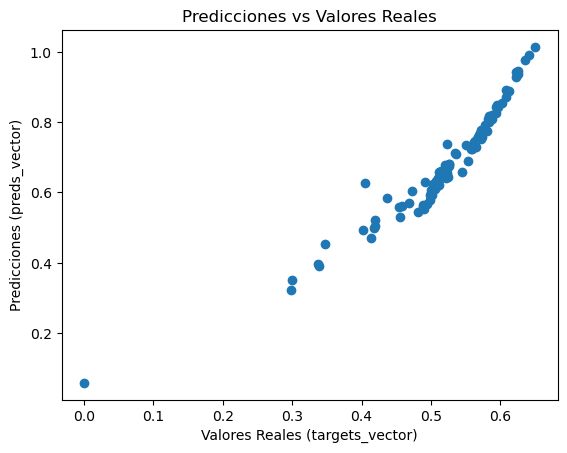

In [32]:
import matplotlib.pyplot as plt

# Supone que preds_vector y targets_vector están definidos
plt.figure()
plt.scatter(targets_vector, preds_vector)
plt.xlabel('Valores Reales (targets_vector)')
plt.ylabel('Predicciones (preds_vector)')
plt.title('Predicciones vs Valores Reales')
plt.show()
